# A deep geothermal doublet

In this notebook, we will take a look at **geothermal doublets**, evaluating some results of a numerical doublet simulation in terms of the temporal behaviour as well as some economic calculations. 
This simulation is run with SHEMAT, a numerical code for simulating heat- and mass transfer in a porous medium. The basis is a synthetic model of a sedimentary, hydrothermal system, with implemented production and injection wells, just as in our project work for the shallow systems. The difference is the higher temperatures and flow rates, which allow producing electricity.

### Introduction 
A geothermal doublet system usually consists of -at least- two boreholes, connected via a surface application installation (such as a powerplant for producing electricity, or an installation for district heating). One geothermal well produces the hot fluid (or steam) from the subsurface. This well is called the producer. The heat of the produced fluid is used accordingly, and the significant cooler fluid is then re-injected in the geothermal reservoir. In the figure to the left, the producing well is marked as a red line, while the injecting well is marked as a blue line, representing the difference in fluid temperature.   

If the heat content of the produced "fluid" is large enough, i.e. *dry or wet steam* is produced, a turbine can be directly operated in one circuit. If the temperatures of the fluide are lower and do not really suffice to operate a turbine directly, a binary cycle is often installed. In such a cycle, the produced fluid heats up a secondary fluid in a heat-exchanger. This secondary fluid has a significantly lower boiling point, an can thus be used to operate a turbine instead (more details in the lecture).  

Operating such a system over a prolonged time will eventually cause a decrease in production temperature, as the cooling front of the re-injected water reaches the producing borehole. The point in time, where production temperature starts to decrease significantly is called a _thermal breakthrough_. In the results of a simplified doublet simulation, which we study in this notebook, we will also look for a thermal breakthrough.

## 3D reservoir model
For assessing this geothermal system, we simulate the heat- and mass transfer in a synthetic, three dimensional model. The model consists of 4 geological units.  

In the plot below, we see a vertical cross-section of the model in x-direction (let's say an East-West cross-section). On the left, you can see the geological units with the inclined reseroir (light green), on the right the temperature field and some arrows indicating the flow during the operation of the doublet. Here, we can clearly see the cooler temperatures around the injection, as well as the flow towards the production well.



<img src='imgs/doublet.png' style=\"float: right; width: 27%; margin-right: 3%; margin-bottom: 0.5em;\">


First, we need to import the data from the monitoring files of the simulation. The model is run with different **production rates**, the first one has a production rate of 50 l per s, the second one 100 l per sec. We want to assess the dfference of both simulations, so we need to import both data sets (each from a monitoring point at the production well).

In [5]:
# import some libraries  
import numpy as np
import pandas as p
import matplotlib.pyplot as plt
%matplotlib inline

headers = ['Time','TimeStep','Head','Vx','Vy','Vz','Por','HydrCond','Perm','Temp','ThermCond','Redox']

data1 = p.read_csv('data/sedres50.002', skiprows=2, names = headers, sep = '\s+')
data2 = p.read_csv('data/sedres100.002', skiprows=2, names = headers, sep = '\s+')
# plot the first 10 lines to check the data file...
data1.head(10)


,Time,TimeStep,Head,Vx,Vy,Vz,Por,HydrCond,Perm,Temp,ThermCond,Redox
0,5.186377,2.535318,1734.540181,-206.606980,-209.026467,-223.376581,0.15,0.000003,5.000000e-14,181.686248,3.0,0.0
1,7.721695,2.535318,1733.893536,-206.567820,-209.006961,-223.390214,0.15,0.000003,5.000000e-14,181.654203,3.0,0.0
2,10.257013,2.535318,1733.732471,-206.562229,-209.009366,-223.380282,0.15,0.000003,5.000000e-14,181.624219,3.0,0.0
3,12.792331,2.535318,1733.634150,-206.562252,-209.012975,-223.368178,0.15,0.000003,5.000000e-14,181.595298,3.0,0.0
4,15.327649,2.535318,1733.547781,-206.562980,-209.016592,-223.356078,0.15,0.000003,5.000000e-14,181.567282,3.0,0.0
5,17.862968,2.535318,1733.460723,-206.563741,-209.020104,-223.344252,0.15,0.000003,5.000000e-14,181.540106,3.0,0.0
6,20.398286,2.535318,1733.379620,-206.564509,-209.023559,-223.332769,0.15,0.000003,5.000000e-14,181.513707,3.0,0.0
7,22.933604,2.535318,1733.311088,-206.565141,-209.026907,-223.321692,0.15,0.000003,5.000000e-14,181.488034,3.0,0.0
8,25.468922,2.535318,1733.252295,-206.566213,-209.030246,-223.310842,0.15,0.000003,5.000000e-14,181.463026,3.0,0.0
9,28.004240,2.535318,1733.186622,-206.566492,-209.033370,-223.300627,0.15,0.000003,5.000000e-14,181.438647,3.0,0.0


Then, we want to plot the temperature for both production rates for the whole simulation period which is 30 years. Consider the time units wich is originally "days". You might want to convert it into "years". Which production rate seems more sustainable?

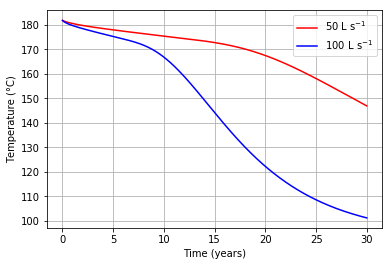

In [14]:
T1=data1['Temp']
T2=data2['Temp']

t1=data1['Time']
t2=data2['Time']

#Days to years
d2y=1/(365.25);
ty1=t1*d2y
ty2=t2*d2y

plt.plot(ty1,T1,'-', color='red',label='50 L s$^{-1}$')
plt.plot(ty2,T2,'-', color='blue',label='100 L s$^{-1}$')

plt.legend()
plt.xlabel('Time (years)')
plt.ylabel('Temperature (°C)')

plt.grid(True)

Now we want to calculate and plot the **electric power** provided by the geothermal power plant according to
$$ P= \Delta T\, \rho c_p\,\dot{V}$$
For this, we need to set some values: use 998 kg m$^{-3}$ for density and 4179 J kg$^{-3}$ for secific heat capacity of the produced fluid. For $\Delta T$, we assume a constant injection temperature of 80°C.

Furthermore, we assume an efficiency of 0.1 and a *parasitic power* of 0.5 MW (used by the systems itself, mainly for the pumps). 


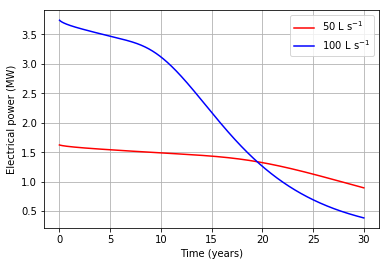

In [18]:
# production rates
Vdot1=0.05
Vdot2=0.1

# Density
rho= 998

# Specific heat capacity
cp = 4179

# Delta T
dT1=T1-80
dT2=T2-80


#Thermal power produced from wells
p1 = cp * rho * Vdot1 * dT1
p2 = cp * rho * Vdot2 * dT2

#Efficiency
eta = 0.1
#Installation consumption (MW)
ic = 0.5e6
#Electrical power
pel1 = eta * p1 - ic
pel2 = eta * p2 - ic


# plotting the electrical power (in MW)
plt.plot(ty1,pel1/1e6,'-', color='red',label='50 L s$^{-1}$')
plt.plot(ty2,pel2/1e6,'-', color='blue',label='100 L s$^{-1}$')

plt.legend()
plt.xlabel('Time (years)')
plt.ylabel('Electrical power (MW)')

plt.grid(True)



Finally, we want to calculate the produced energy, since the financial gain is calculated from selling energy at a price of 0.25 € per kWh (German feed-in tariff, EEG) and compare it with the invest of 46 million €.
For calculating this cumulative energy, we need to know the time step size, which is stored in the monitoring file as well. 
What is the pay-off time?

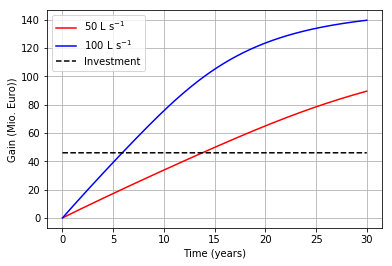

In [36]:
# Time step size for both cases (originally in days!)

dt1=data1['TimeStep']
dt2=data2['TimeStep']

# Calculating the energy produced in each time step

Eelstep1=pel1*dt1*24*60*60
Eelstep2=pel2*dt2*24*60*60

# Cumulative energy during the 30 years of operation in Joule
Eel1=np.cumsum(Eelstep1)
Eel2=np.cumsum(Eelstep2)

#Converting to kWh:
Eel1kWh=Eel1/3.6e6
Eel2kWh=Eel2/3.6e6

#Payment in Germany - EEG (Euro/kWh)
EEG=0.25

#Investment (Mio. Euro) (for plotting as an array with the same length as pel1)
invest = np.ones(len(pel1))*46;

# Gain in Mio EUR
G1=Eel1kWh*EEG/1e6
G2=Eel2kWh*EEG/1e6

# plotting the gain (in Mio EUR)
plt.plot(ty1,G1,'-', color='red',label='50 L s$^{-1}$')
plt.plot(ty2,G2,'-', color='blue',label='100 L s$^{-1}$')
plt.plot(ty1,invest,'--', color='black',label='Investment')


plt.legend()
plt.xlabel('Time (years)')
plt.ylabel('Gain (Mio. Euro))')

plt.grid(True)
